#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_california_housing

import lightgbm as lgbm
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

sns.set_theme(style='darkgrid')

#### Data

In [2]:
# Constants
train_set = pd.read_csv("../data/raw/train.csv")
test_set = pd.read_csv("../data/raw/test.csv")
sample_sub = pd.read_csv("../data/raw/sample_submission.csv")

In [3]:
# Load original dataset
original = fetch_california_housing()
features = train_set.columns[1:-1]
df_original = pd.DataFrame(original['data'], columns=features)
df_original['MedHouseVal'] = original['target']

In [4]:
train_set.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


#### Exploratory Data Analysis

In [5]:
# Data Size
print(f"train_set shape: {train_set.shape}")
print(f"test_set shape: {test_set.shape}")
print(f"original shape: {df_original.shape}")

train_set shape: (37137, 10)
test_set shape: (24759, 9)
original shape: (20640, 9)


In [6]:
# Info about the data
train_set.describe()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,37137.00000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000
mean,18568.00000,3.851029,26.057005,5.163124,1.062204,1660.778919,2.831243,35.570030,-119.554329,2.079751
std,10720.67281,1.803167,12.158221,1.206242,0.096490,1302.469608,2.702413,2.083179,1.974028,1.158571
min,0.00000,0.499900,2.000000,0.851064,0.500000,3.000000,0.950000,32.550000,-124.350000,0.149990
25%,9284.00000,2.602300,17.000000,4.357522,1.020305,952.000000,2.394495,33.930000,-121.800000,1.208000
50%,18568.00000,3.515600,25.000000,5.068611,1.054545,1383.000000,2.744828,34.190000,-118.450000,1.808000
75%,27852.00000,4.699700,35.000000,5.858597,1.088825,1856.000000,3.125313,37.700000,-118.020000,2.660000
max,37136.00000,15.000100,52.000000,28.837607,5.873181,35682.000000,502.990610,41.950000,-114.550000,5.000010


#### Missing Data

In [7]:
total = train_set.isnull().sum().sort_values(ascending=False)
percent = (train_set.isnull().sum()/train_set.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data

,Total,Percent
id,0,0.0
MedInc,0,0.0
HouseAge,0,0.0
AveRooms,0,0.0
AveBedrms,0,0.0
Population,0,0.0
AveOccup,0,0.0
Latitude,0,0.0
Longitude,0,0.0
MedHouseVal,0,0.0


In [8]:
# Original data
total = df_original.isnull().sum().sort_values(ascending=False)
percent = (df_original.isnull().sum()/df_original.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data

,Total,Percent
MedInc,0,0.0
HouseAge,0,0.0
AveRooms,0,0.0
AveBedrms,0,0.0
Population,0,0.0
AveOccup,0,0.0
Latitude,0,0.0
Longitude,0,0.0
MedHouseVal,0,0.0


#### Data Visualisation

In [9]:
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
target = ['MedHouseVal']

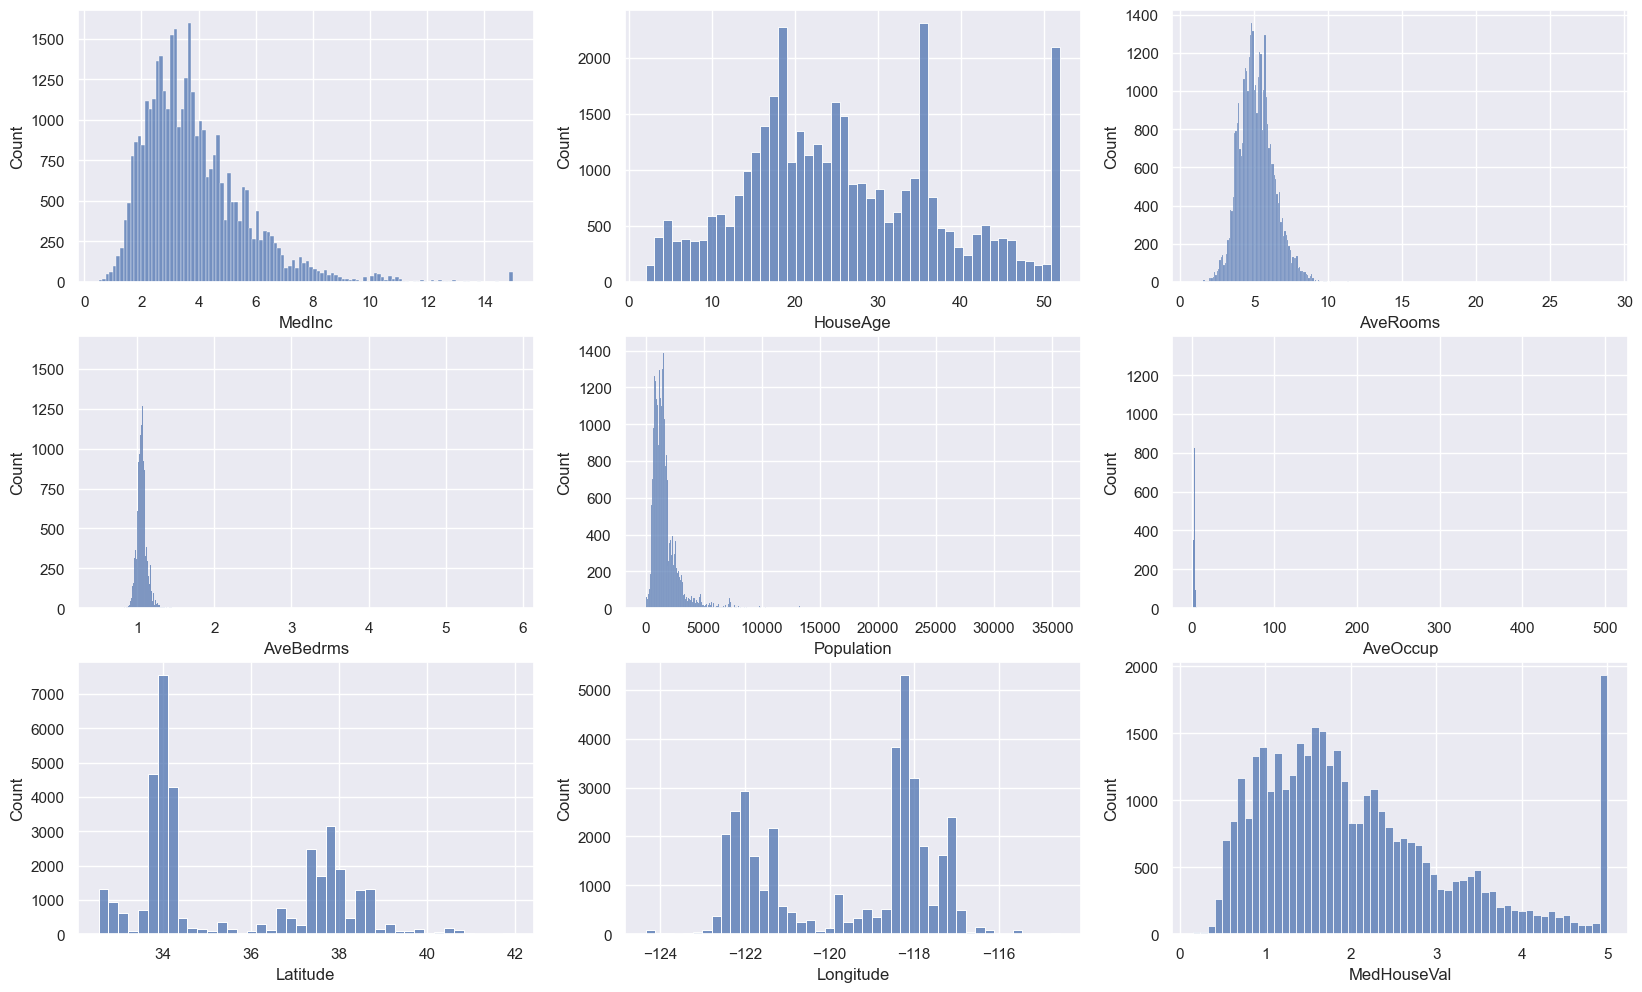

In [10]:
# Data Distributions
fig, axes = plt.subplots(3,3, figsize=(20, 12))
for i,j in zip(features+target, axes.flatten()):
    sns.histplot(train_set[i], ax=j)
plt.show()

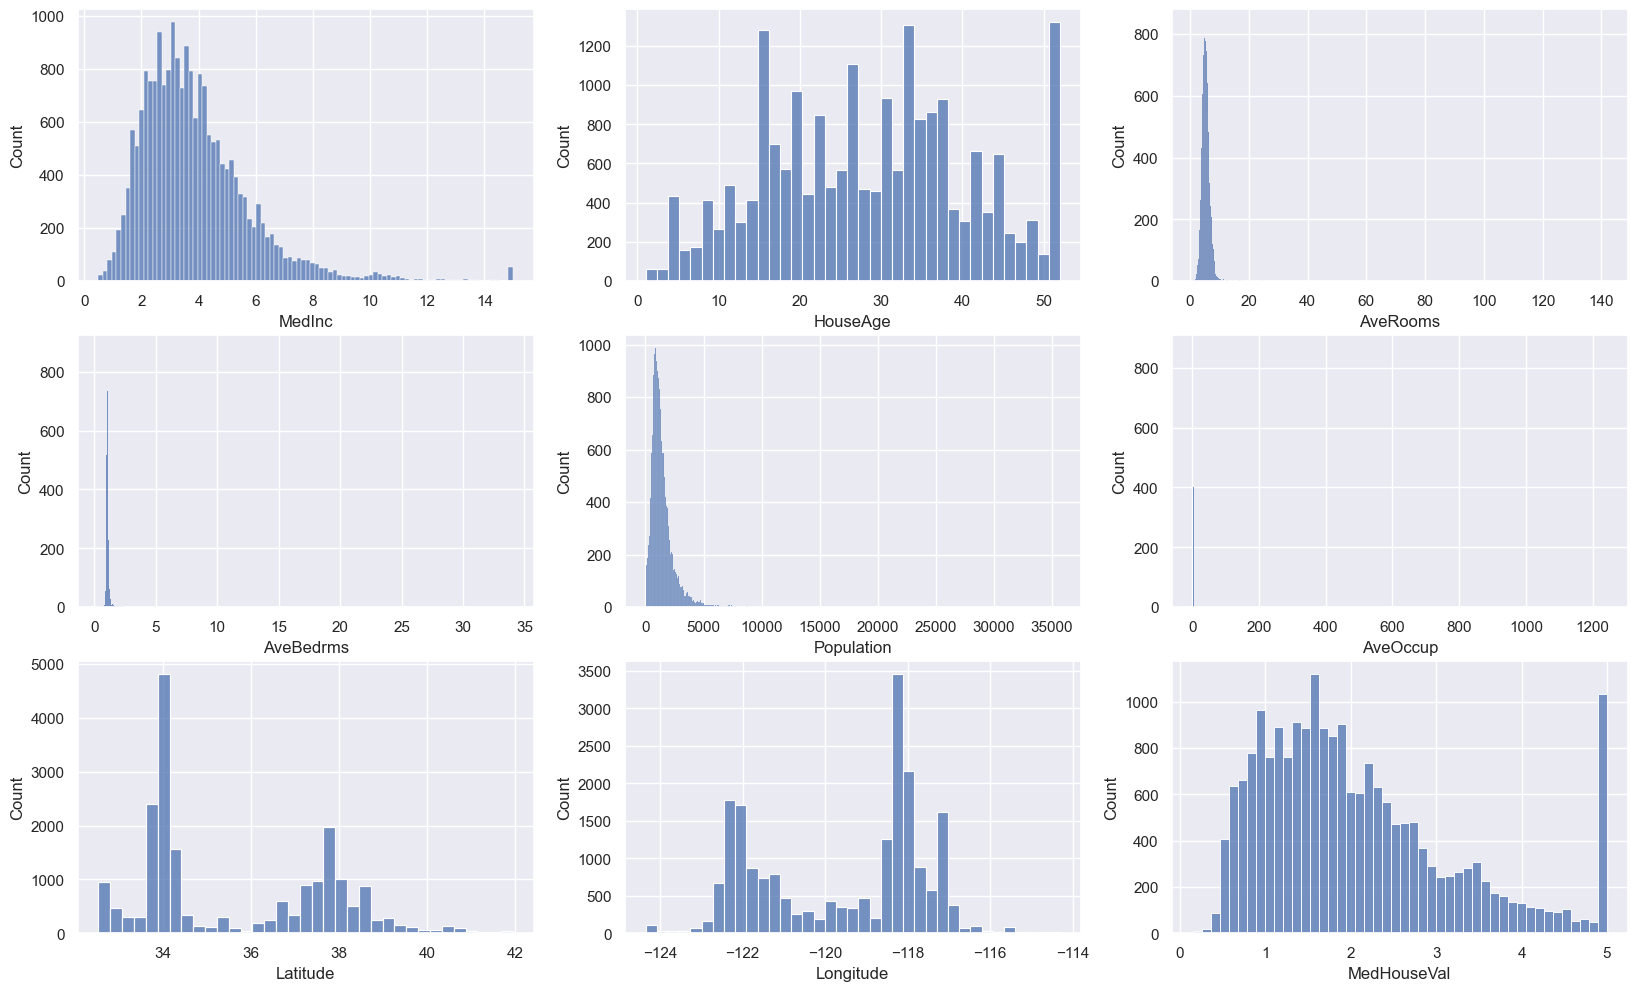

In [11]:
# Original data
fig, axes = plt.subplots(3,3, figsize=(20, 12))
for i, j in zip(features+target, axes.flatten()):
    sns.histplot(df_original[i], ax=j)
plt.show()

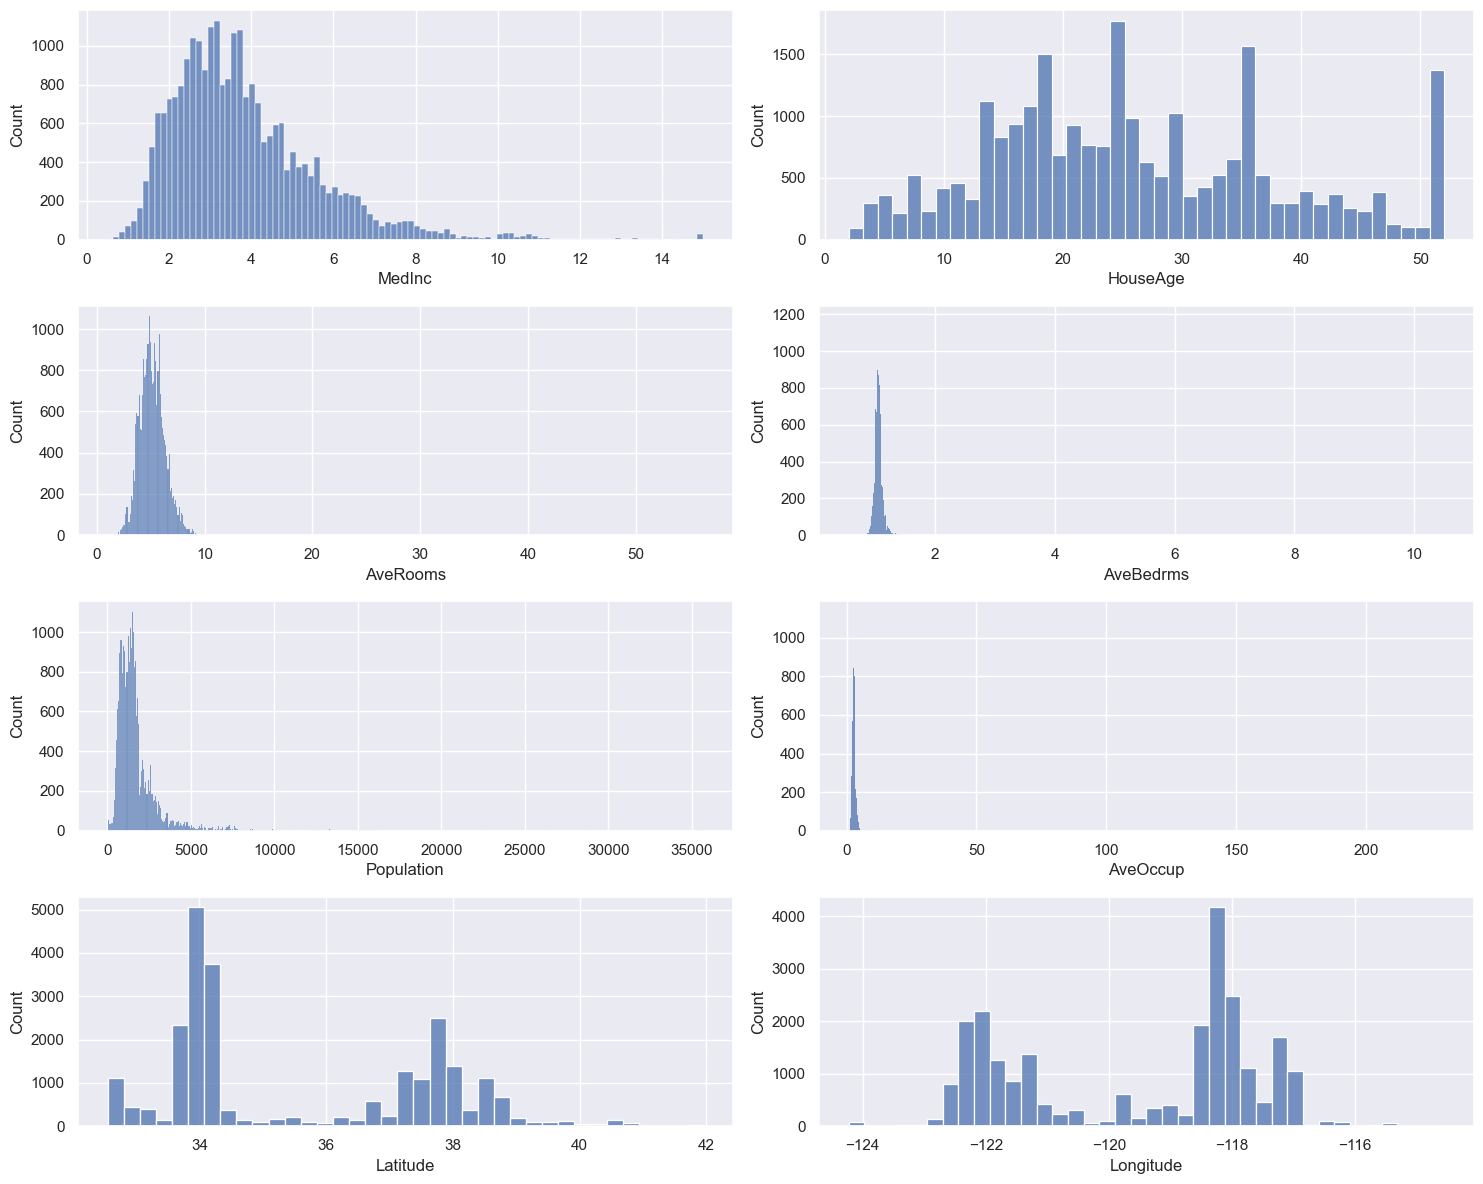

In [12]:
# Test set
fig, axes = plt.subplots(4,2, figsize=(15, 12))
for i, j in zip(features+target, axes.flatten()):
    sns.histplot(test_set[i], ax=j)
fig.tight_layout()
plt.show()

#### Bivariate Distribution with Target

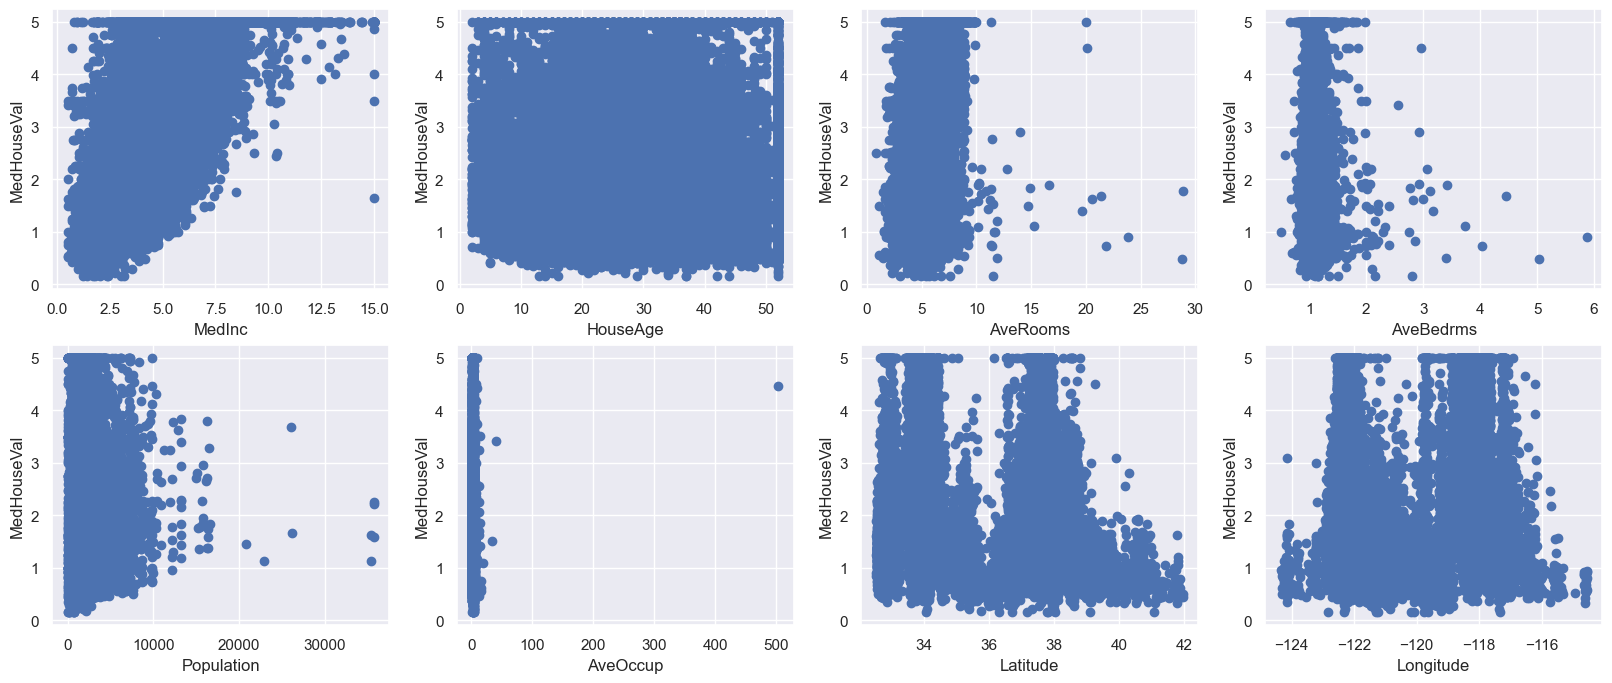

In [13]:
fig, axs = plt.subplots(2,4, figsize=(20, 8))
for i, j in enumerate(features):
    var = j
    plt.subplot(2,4,i+1)
    data = pd.concat([train_set['MedHouseVal'], train_set[var]], axis=1)
    plt.scatter(x=data[var], y=data['MedHouseVal'])
    plt.xlabel(j)
    plt.ylabel('MedHouseVal')
plt.show()

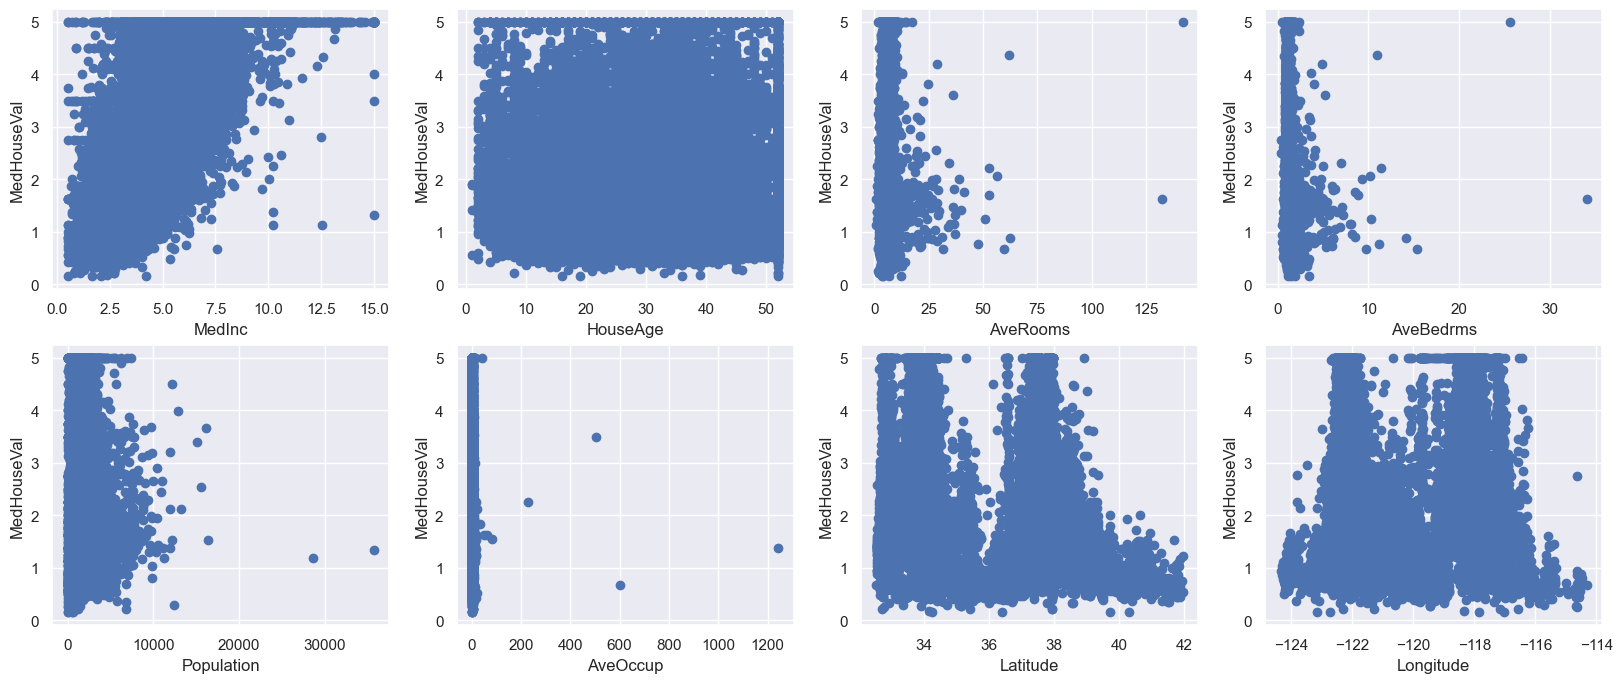

In [14]:
fig, axs = plt.subplots(2,4, figsize=(20, 8))
for i, j in enumerate(features):
    var = j
    plt.subplot(2,4,i+1)
    data = pd.concat([df_original['MedHouseVal'], df_original[var]], axis=1)
    plt.scatter(x=data[var], y=data['MedHouseVal'])
    plt.xlabel(j)
    plt.ylabel('MedHouseVal')
plt.show()

#### Correlation matrix (Heatmap Style)

<AxesSubplot: >

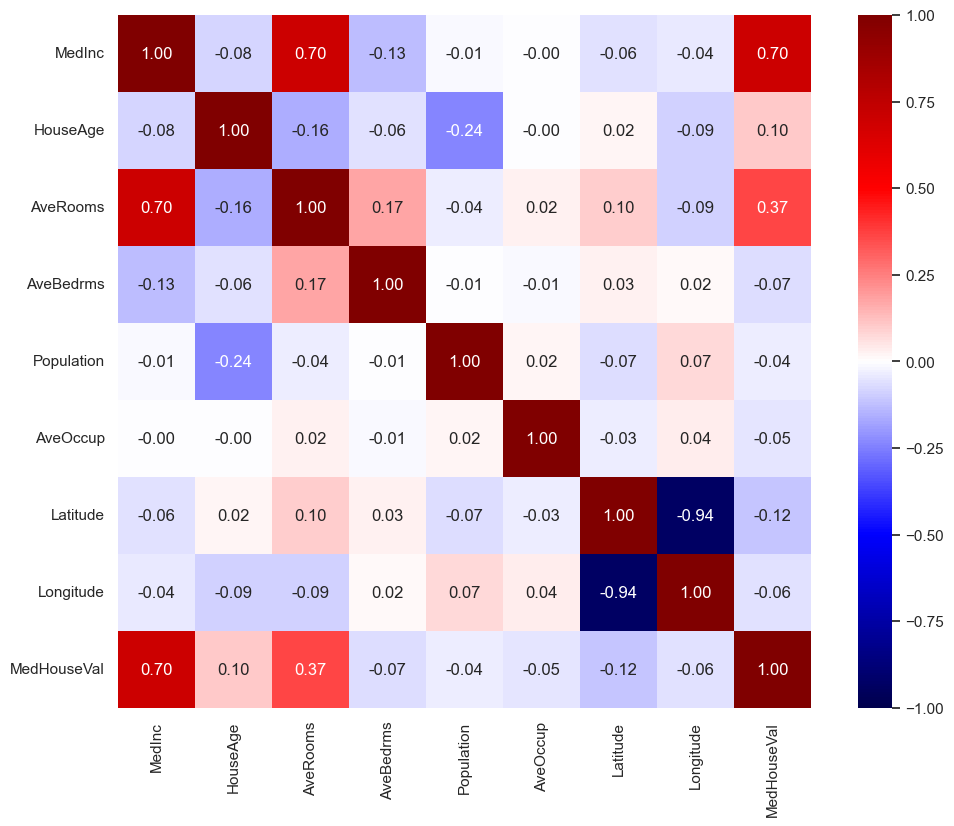

In [15]:
# Train set
corrmat = train_set[features+target].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True, fmt='.2f', cmap='seismic', vmin=-1, vmax=1)

<AxesSubplot: >

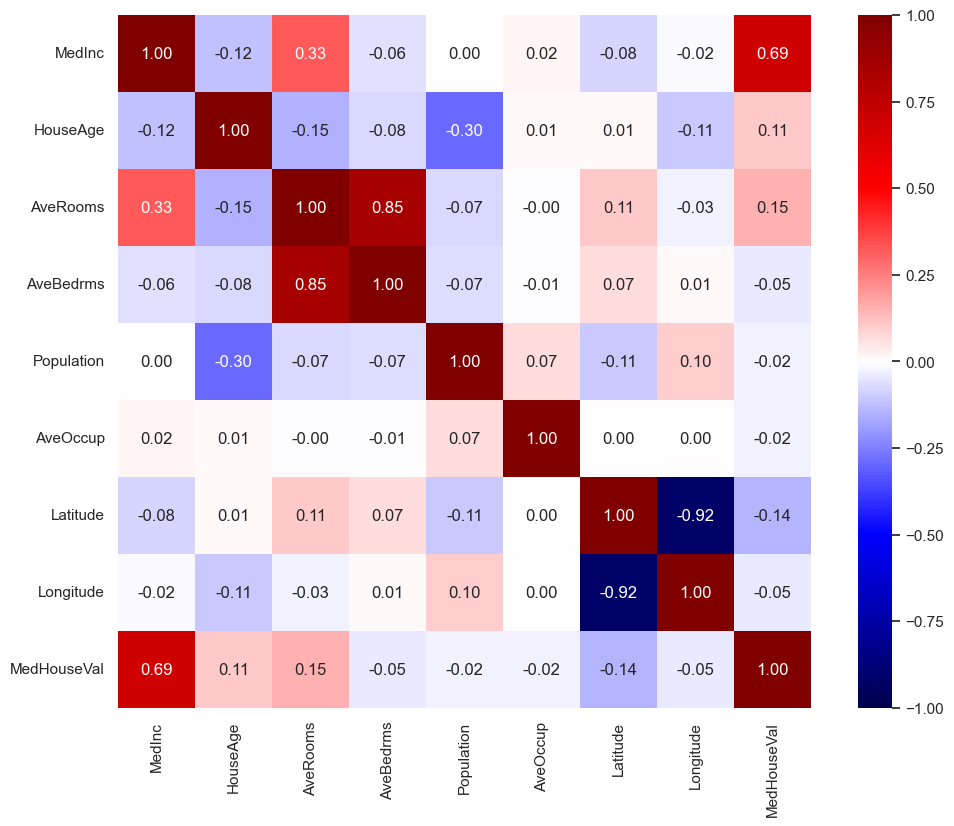

In [16]:
# Original data
corrmat = df_original[features+target].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True, fmt='.2f', cmap='seismic', vmin=-1, vmax=1)

#### Longitude and Latitude

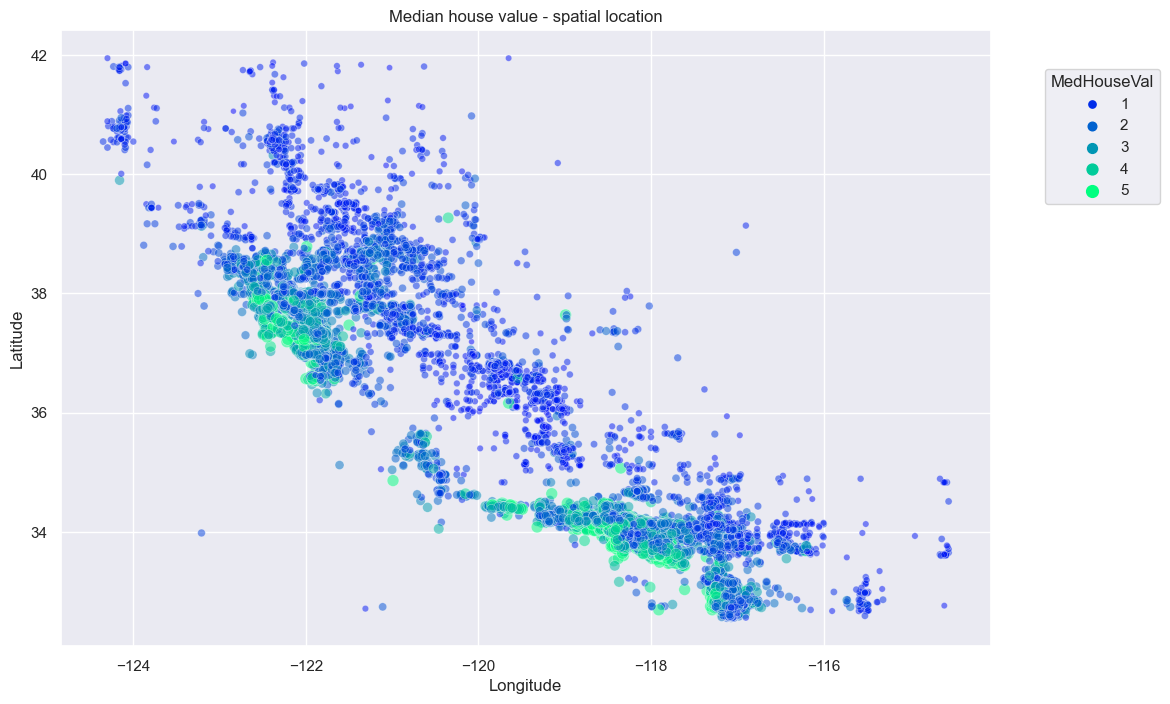

In [17]:
# Rotating the coordinates, they may provide more spatial information
plt.figure(figsize = (12, 8))
sns.scatterplot(data = train_set, x = "Longitude", y = "Latitude",
                size = "MedHouseVal", hue = "MedHouseVal", palette = "winter", 
                alpha = 0.5)
plt.legend(title = "MedHouseVal", bbox_to_anchor = (1.05, 0.95), loc = 2)
plt.title("Median house value - spatial location")
plt.show()

In [18]:
def rt_crds(df):
    
    df['rot_15_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                     (np.sin(np.radians(15)) * df['Latitude'])
    
    df['rot_15_y'] = (np.cos(np.radians(15)) * df['Latitude']) - \
                     (np.sin(np.radians(15)) * df['Longitude'])
    
    df['rot_30_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                     (np.sin(np.radians(15)) * df['Latitude'])
    
    df['rot_30_y'] = (np.cos(np.radians(15)) * df['Latitude']) - \
                     (np.sin(np.radians(15)) * df['Longitude'])
    
    df['rot_45_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                     (np.sin(np.radians(15)) * df['Latitude'])
    
    df['rot_45_y'] = (np.cos(np.radians(15)) * df['Latitude']) - \
                     (np.sin(np.radians(15)) * df['Longitude'])
    
    return df

df_original = rt_crds(df_original)
train_set = rt_crds(train_set)
test_set = rt_crds(test_set)

#### Rotating the coordinates

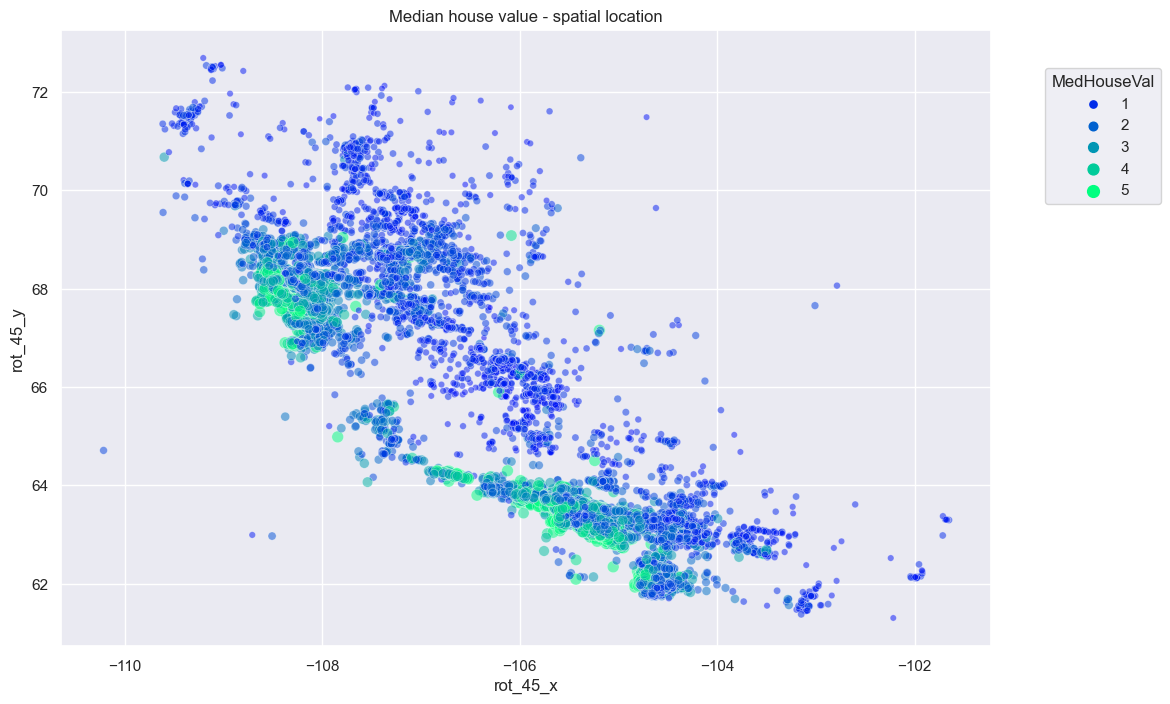

In [19]:
plt.figure(figsize = (12, 8))

sns.set_theme(style="darkgrid")
sns.scatterplot(data = train_set, x = "rot_45_x", y = "rot_45_y", 
                size = "MedHouseVal", hue = "MedHouseVal", palette = "winter", 
                alpha = 0.5)

plt.legend(title = "MedHouseVal", bbox_to_anchor = (1.05, 0.95), loc = 2)
plt.title("Median house value - spatial location")
plt.show()

#### Train Model

In [21]:
# Adding a feature to denote if the data is generated or not
df_original['is_generated'] = 0
train_set['is_generated'] = 1
test_set['is_generated'] = 1

In [22]:
train_concat = pd.concat([train_set.drop('id', axis=1), df_original]).reset_index(drop=True)

In [23]:
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 
            'is_generated', 'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y']
target = ['MedHouseVal']

#### XGBRegressor

In [25]:
import warnings
warnings.filterwarnings('ignore')
kf = KFold(n_splits=10, random_state=42, shuffle=True)
clfs = []
err = []

for i, (train_index, val_index) in enumerate(kf.split(train_concat)):
    X_train, X_val = train_concat[features].loc[train_index], train_concat[features].loc[val_index]
    y_train, y_val = train_concat['MedHouseVal'][train_index], train_concat['MedHouseVal'][val_index]
    
    clf = XGBRegressor(n_estimators=20000,
                       max_depth=9,
                       learning_rate=0.01,
                       colsample_bytree=0.66,
                       subsample=0.9,
                       min_child_weight=22,
                       reg_lambda=16,
                       tree_method='gpu_hist',
                       seed=42)
    
    clf.fit(X_train.values, y_train,
            early_stopping_rounds=100, 
            eval_set=[(X_val.values, y_val)], 
            verbose=1000)
    
    preds = clf.predict(X_val.values)
    
    rmse = mean_squared_error(y_val, preds, squared=False)
    err.append(rmse)
    clfs.append(clf)
    print(f'RMSE on fold {i}: {rmse}')
    print('-'*50)

print(f'Average RMSE (five fold): {sum(err)/10}')

[0]	validation_0-rmse:1.93247
[1000]	validation_0-rmse:0.50426
[1850]	validation_0-rmse:0.50233
RMSE on fold 0: 0.5023127741661577
--------------------------------------------------
[0]	validation_0-rmse:1.93488
[1000]	validation_0-rmse:0.50012
[2000]	validation_0-rmse:0.49588
[2927]	validation_0-rmse:0.49481
RMSE on fold 1: 0.49473188546973995
--------------------------------------------------
[0]	validation_0-rmse:1.94162
[1000]	validation_0-rmse:0.52067
[2000]	validation_0-rmse:0.51680
[2546]	validation_0-rmse:0.51606
RMSE on fold 2: 0.5160398325524349
--------------------------------------------------
[0]	validation_0-rmse:1.91120
[1000]	validation_0-rmse:0.51399
[1538]	validation_0-rmse:0.51251
RMSE on fold 3: 0.51241939374538
--------------------------------------------------
[0]	validation_0-rmse:1.95770
[1000]	validation_0-rmse:0.52850
[2000]	validation_0-rmse:0.52490
[2536]	validation_0-rmse:0.52444
RMSE on fold 4: 0.5243521342716033
-------------------------------------------

#### LGBMRegressor

In [26]:
err = []

for i, (train_index, val_index) in enumerate(kf.split(train_concat)):
    X_train, X_val = train_concat[features].loc[train_index], train_concat[features].loc[val_index]
    y_train, y_val = train_concat['MedHouseVal'][train_index], train_concat['MedHouseVal'][val_index]
    
    clf = lgbm.LGBMRegressor(learning_rate=0.01,
                             max_depth=9,
                             num_leaves=90,
                             colsample_bytree=0.8,
                             subsample=0.9,
                             subsample_freq=5,
                             min_child_samples=36,
                             reg_lambda=28,
                             n_estimators=20000,
                             metric='rmse',
                             random_state=42)
    
    clf.fit(X_train.values, y_train, eval_set=[(X_val.values, y_val)], callbacks=[lgbm.early_stopping(100, verbose=True)])
    
    preds = clf.predict(X_val.values)
    
    rmse = mean_squared_error(y_val, preds, squared=False)
    err.append(rmse)
    clfs.append(clf)
    print(f'RMSE on fold {i}: {rmse}')
    print('-'*50)

print(f'Average RMSE (five fold): {sum(err)/10}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1526]	valid_0's rmse: 0.505941
RMSE on fold 0: 0.5059410021594459
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2656]	valid_0's rmse: 0.497693
RMSE on fold 1: 0.49769328727897194
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3488]	valid_0's rmse: 0.519943
RMSE on fold 2: 0.5199430225574501
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2015]	valid_0's rmse: 0.514149
RMSE on fold 3: 0.5141491146194102
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2891]	valid_0's rmse: 0.525604
RMSE on fo

#### CatBoostRegressor

In [27]:
err = []

for i, (train_index, val_index) in enumerate(kf.split(train_concat)):
    X_train, X_val = train_concat[features].loc[train_index], train_concat[features].loc[val_index]
    y_train, y_val = train_concat['MedHouseVal'][train_index], train_concat['MedHouseVal'][val_index]
    
    clf = CatBoostRegressor(iterations=20000,
                            depth=9,
                            learning_rate=0.01,
                            rsm=0.88,
                            subsample=0.795,
                            min_data_in_leaf=35,
                            l2_leaf_reg=8,
                            random_strength=0.63,
                            bootstrap_type='Bernoulli',
                            grow_policy='SymmetricTree',
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            task_type="CPU",
                            random_state=42)
    
    clf.fit(X_train.values, y_train, eval_set=(X_val.values, y_val), early_stopping_rounds=100, verbose=1000)
    
    preds = clf.predict(X_val.values)
    
    rmse = mean_squared_error(y_val, preds, squared=False)
    err.append(rmse)
    clfs.append(clf)
    print(f'RMSE on fold {i}: {rmse}')
    print('-'*50)

print(f'Average RMSE (five fold): {sum(err)/10}')

0:	learn: 1.1513372	test: 1.1360223	best: 1.1360223 (0)	total: 158ms	remaining: 52m 41s
1000:	learn: 0.5244943	test: 0.5258410	best: 0.5258410 (1000)	total: 24.3s	remaining: 7m 40s
2000:	learn: 0.4935007	test: 0.5152365	best: 0.5152365 (2000)	total: 47.5s	remaining: 7m 6s
3000:	learn: 0.4724400	test: 0.5117145	best: 0.5117145 (3000)	total: 1m 10s	remaining: 6m 40s
4000:	learn: 0.4554327	test: 0.5100283	best: 0.5100152 (3994)	total: 1m 33s	remaining: 6m 15s
5000:	learn: 0.4404113	test: 0.5093140	best: 0.5093095 (4940)	total: 1m 57s	remaining: 5m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5090240583
bestIteration = 5497

Shrink model to first 5498 iterations.
RMSE on fold 0: 0.5090240576992306
--------------------------------------------------
0:	learn: 1.1491973	test: 1.1554071	best: 1.1554071 (0)	total: 25.1ms	remaining: 8m 22s
1000:	learn: 0.5245365	test: 0.5281226	best: 0.5281226 (1000)	total: 23.2s	remaining: 7m 19s
2000:	learn: 0.4938821	test: 0.514739

#### Feature Importance

----------------------------XGBoost----------------------------


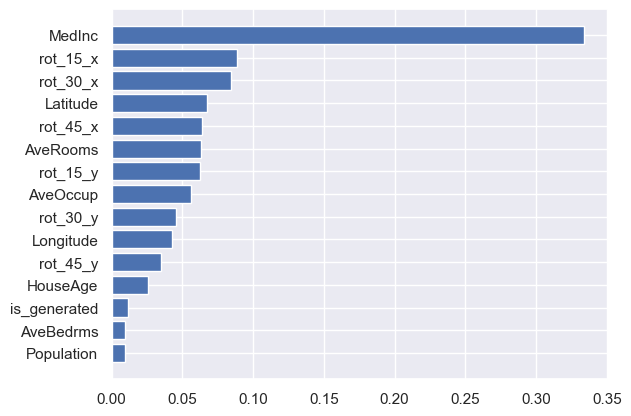

In [28]:
imp = np.zeros(15)
for clf in clfs[:10]:
    imp+= clf.feature_importances_
    
print('----------------------------XGBoost----------------------------')
plt.barh([features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

----------------------------LGBM----------------------------


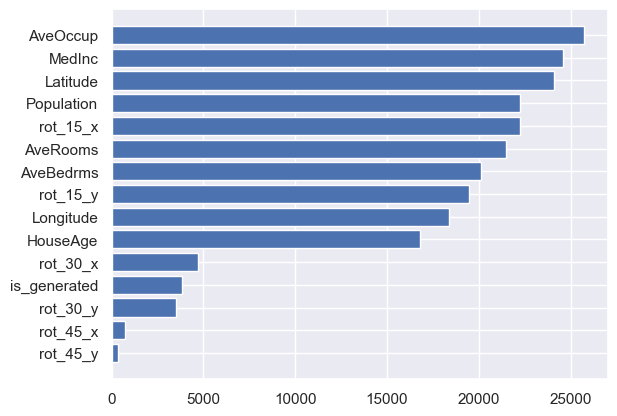

In [29]:
imp = np.zeros(15)
for clf in clfs[10:20]:
    imp+= clf.feature_importances_
    
print('----------------------------LGBM----------------------------')
plt.barh([features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

----------------------------CatBoost----------------------------


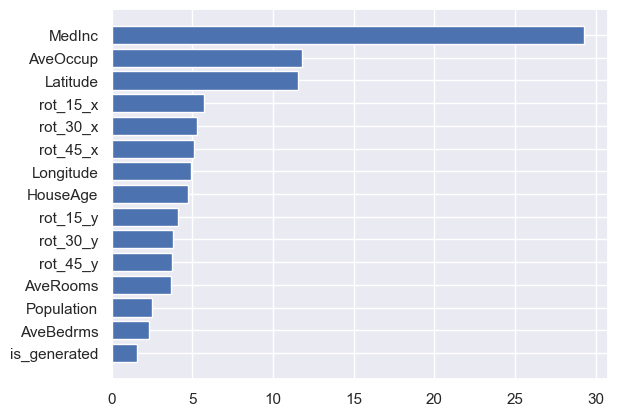

In [30]:
imp = np.zeros(15)
for clf in clfs[20:]:
    imp+= clf.feature_importances_
    
print('----------------------------CatBoost----------------------------')
plt.barh([features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

#### Testing on Test Set

In [31]:
test_preds1 = []
test_preds2 = []
test_preds3 = []

for clf in clfs[:10]:
    preds = clf.predict(test_set[features].values)
    test_preds1.append(preds)
    
for clf in clfs[10:20]:
    preds = clf.predict(test_set[features].values)
    test_preds2.append(preds)
    
for clf in clfs[20:]:
    preds = clf.predict(test_set[features].values)
    test_preds3.append(preds)

In [32]:
test_preds1 = np.stack(test_preds1).mean(0)
test_preds2 = np.stack(test_preds2).mean(0)
test_preds3 = np.stack(test_preds3).mean(0)

In [33]:
test_preds = test_preds1*0.6 + test_preds2*0.3 + test_preds3*0.1


In [34]:
submission = pd.DataFrame(data={'id': test_set.id, 'MedHouseVal': test_preds})
submission.head()

,id,MedHouseVal
0,37137,0.637036
1,37138,1.022758
2,37139,4.105800
3,37140,3.264340
4,37141,2.478544


In [35]:
vals = train_set['MedHouseVal'].unique().tolist()
submission['MedHouseVal'] = submission['MedHouseVal'].apply(lambda x: min(vals, key=lambda v: abs(v - x)))
submission.head()

,id,MedHouseVal
0,37137,0.637
1,37138,1.023
2,37139,4.105
3,37140,3.265
4,37141,2.479


In [39]:
submission.to_csv('submission.csv', index=False)